In [11]:
## Importing Packages

import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline

## Logistic
from sklearn.linear_model import LogisticRegression
### Random Forest
from sklearn.ensemble import RandomForestClassifier
### KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
### Getting Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier 
### Linear SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
## Reading in the data
stellar_features = pd.read_csv("stellar_features.csv", index_col = 0)

### Checking data

In [4]:
print("Sample Shape :\n{} \n".format(stellar_features.shape))
print("Sample Data Types :\n{} \n".format(stellar_features.dtypes))

Sample Shape :
(87939, 7) 

Sample Data Types :
u           float64
g           float64
r           float64
i           float64
z           float64
redshift    float64
class        object
dtype: object 



In [5]:
print(stellar_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87939 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         87939 non-null  float64
 1   g         87939 non-null  float64
 2   r         87939 non-null  float64
 3   i         87939 non-null  float64
 4   z         87939 non-null  float64
 5   redshift  87939 non-null  float64
 6   class     87939 non-null  object 
dtypes: float64(6), object(1)
memory usage: 5.4+ MB
None


In [50]:
features = ['u','g','r','i','z','redshift']
classes = stellar_features["class"].unique()
stellar_features.describe()

,u,g,r,i,z,redshift
count,87939.000000,87939.000000,87939.000000,87939.000000,87939.000000,87939.000000
mean,22.076154,20.630654,19.640179,19.079038,18.761662,0.583572
std,2.255119,2.039452,1.849442,1.751695,1.758200,0.734421
min,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971
25%,20.341365,18.960475,18.127585,17.726360,17.452335,0.060015
50%,22.166240,21.097100,20.130540,19.411060,19.009440,0.427993
75%,23.693860,22.111265,21.034150,20.387805,19.911320,0.705997
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


In [8]:
print(features)

['u', 'g', 'r', 'i', 'z', 'redshift']


In [9]:
## Checking the classes
print(stellar_features["class"].unique())

## Saving class as a category
stellar_features["class"] = stellar_features["class"].astype("category")
stellar_features.dtypes

['GALAXY' 'QSO' 'STAR']


u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
class       category
dtype: object

#### Type casted to category for efficiency


                 u         g         r         i         z  redshift
u         1.000000  0.853347  0.727495  0.615436  0.541491  0.158087
g         0.853347  1.000000  0.931925  0.844366  0.770890  0.312706
r         0.727495  0.931925  1.000000  0.962108  0.917534  0.431491
i         0.615436  0.844366  0.962108  1.000000  0.971108  0.493881
z         0.541491  0.770890  0.917534  0.971108  1.000000  0.503812
redshift  0.158087  0.312706  0.431491  0.493881  0.503812  1.000000


<AxesSubplot:>

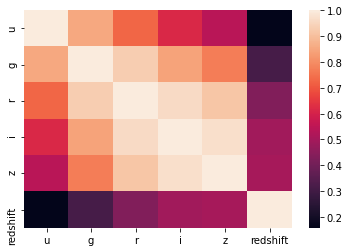

In [12]:
## Checking and handling multicollinearity
print(stellar_features.corr())
sns.heatmap(stellar_features.corr())


We will use PCA to de-correlate the features

In [75]:
class_col = stellar_features["class"].values

<BarContainer object of 6 artists>

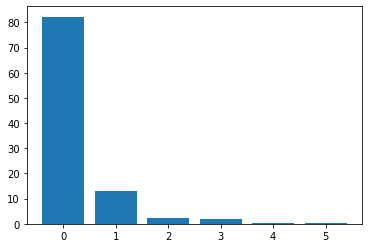

In [70]:
#### PCA

## Fitting PCA to the features
from sklearn.decomposition import PCA
model = PCA()

model.fit(stellar_features[features].values)

pca_comps = range(model.n_components_)

plt.bar(pca_comps, [(x * 100)/sum(model.explained_variance_) for x in [model.explained_variance_]][0])

##### Since almost all of the variance is explained by the first 4 components, we will fit PCA again with 4 components only and then transform the features for modelling.

In [130]:
## Fitting PCA
model = PCA(n_components=4)
stellar_transformed = model.fit_transform(stellar_features[features].values)
stellar_transformed.shape

(87939, 4)

In [143]:
## Adding class col to the PCA transformed features array
stellar_transformed_1 = np.concatenate((stellar_transformed, np.array(class_var).reshape(-1 , 1)), 1)

In [144]:
## Checking the shape of the data
stellar_transformed_1.shape

(87939, 5)

In [217]:
## Creating a dataframe for modeling
stellar_transformed_2 = pd.DataFrame(\
                                     stellar_transformed_1, \
                                     columns = ["X" + str(x) for x in range(1,5)]+["Class"]\
                                    )
stellar_transformed_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87939 entries, 0 to 87938
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X1      87939 non-null  object
 1   X2      87939 non-null  object
 2   X3      87939 non-null  object
 3   X4      87939 non-null  object
 4   Class   87939 non-null  object
dtypes: object(5)
memory usage: 3.4+ MB


<AxesSubplot:>

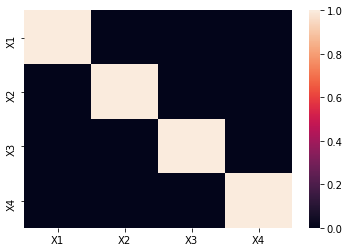

In [228]:
## Checking again for multicllinearity (all correlations would be almost 0)
sns.heatmap(stellar_transformed_2.loc[:,["X1", "X2", "X3", "X4"]].astype("float32").corr())

In [229]:
## Checking the transformed features and classes dataframe created
stellar_transformed_2.head()

,X1,X2,X3,X4,Class
0,-2.062571,-1.406595,-0.235219,0.453537,GALAXY
1,-5.686756,0.340716,0.210096,-0.636528,GALAXY
2,-3.146103,-2.310178,0.131141,0.240929,GALAXY
3,6.742798,-0.879236,-0.021228,0.301465,GALAXY
4,-3.618403,-0.216971,-0.37996,1.243353,QSO
...,...,...,...,...,...
87934,-5.052316,-2.181713,-0.361496,0.402674,GALAXY
87935,-2.044937,-0.071745,-0.774017,0.295611,GALAXY
87936,2.903745,-0.631386,-0.044715,-0.107984,GALAXY
87937,-2.113288,-2.622769,0.632442,-0.314636,GALAXY


#### Minimal Correlation

### Creating train and test splits

In [347]:
X_train, X_test, y_train, y_test = train_test_split(stellar_transformed_2.iloc[:,:-1],\
                                                    stellar_transformed_2.iloc[:,-1], \
                                                    test_size=0.2,\
                                                    stratify=stellar_transformed_2.iloc[:,-1],random_state=21)

print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(70351, 4)
(17588, 4)
(70351,)
(17588,)


### Encoding target variable

In [349]:
le = LabelEncoder()
y_train = le.fit_transform(y_train[:])
y_test = le.transform(y_test[:])


## Modeling Iteration 1

In [394]:
print(stellar_cv_classifier.__doc__)

This function returns a GridSearchCV object and prints some accuracy scores.
        Model can take the values: Logistic, RandomForest, KNN, GBC, SVC.
        Scaler can be min_max(0,1) or standard.
        
        Create params just like you would for GridSearchCV in pipeline. 
        params = {'Classifier__(parameter name))}':[Parameter Values List]}
        Example : parameters = {'Classifier__n_neighbors': [6,7]} 


#### Writing a function to take in the training data, parameters grid and classifier algorithm, and use these to build a model, with 4-fold cross validation and a grid search over the parameters.

In [395]:
## KNN default n_neighbors set to 6. No particular reason as of now. It will be updated later in grid search.

def stellar_cv_classifier(model, X, y, params, scaler):
    """This function returns a GridSearchCV object and prints some accuracy scores.
        Model can take the values: Logistic, RandomForest, KNN, GBC and SVC.
        Scaler can be min_max(0,1) or standard.
        
        Create params just like you would for GridSearchCV in pipeline. 
        params = {'Classifier__(parameter name))}':[Parameter Values List]}
        Example : parameters = {'Classifier__n_neighbors': [6,7]} """
    
    
    
    if scaler == "standard":
        scaler = StandardScaler()
    elif scaler == "min_max":
        scaler = MinMaxScaler((0,1))
    
    if model == "Logistic":
        classifier = LogisticRegression(max_iter=1000)
    
    elif model == "RandomForest":
        classifier = RandomForestClassifier(random_state=123)

    elif model == "KNN":
        classifier = KNeighborsClassifier(n_neighbors = 6) 

    elif model == "GBC":
        classifier = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=20)
    
    elif model == "LinearSVC":
        classifier = LinearSVC(random_state=20)
        


    #### Setting the pipeline
    steps = [("Scaler",scaler),("Classifier",classifier)]
    model_pipeline = Pipeline(steps)



    cv = GridSearchCV(model_pipeline, param_grid=params, cv = 4)
    cv.fit(X, y)
    
    #### Evaluation
    print("Best Parameters {}".format(cv.best_params_))
    print("\n CV Accuracy {}".format(cv.best_score_*100))


    #### Error Analysis
    print("Error Analysis")
    y_pred = cv.predict(X)
    print("\n Confusion Matrix: \n")
    print(confusion_matrix(y, y_pred))
    
    return(cv)



##### Building a basic logistic regression model

In [351]:
logreg_parameters = {'Classifier__max_iter': [1000]}
logreg = stellar_cv_classifier(model = "Logistic", X = X_train, y = y_train, params = logreg_parameters, scaler = "standard")

print("\n Train Accuracy ",logreg.score(X_train,y_train)*100)
print("\n Test Accuracy ",logreg.score(X_test,y_test)*100)


Best Parameters {'Classifier__max_iter': 1000}

 CV Accuracy 95.41442152253407
Error Analysis

 Confusion Matrix: 

[[40151   700   841]
 [ 1580 12209     8]
 [   57    11 14794]]

 Train Accuracy  95.45564384301574

 Test Accuracy  95.5253581987719


##### Fitting a random forest model

In [363]:
rf_parameters = {'Classifier__n_estimators': [400], 'Classifier__min_samples_leaf':[0.15]}
rf = stellar_cv_classifier(model = "RandomForest", X = X_train, y = y_train, params = rf_parameters, scaler = "standard")

print("\n Train Accuracy ",rf.score(X_train,y_train)*100)
print("\n Test Accuracy ",rf.score(X_test,y_test)*100)


Best Parameters {'Classifier__min_samples_leaf': 0.15, 'Classifier__n_estimators': 400}

 CV Accuracy 78.09554795064825
Error Analysis

 Confusion Matrix: 

[[38685  1278  1729]
 [ 1824 11080   893]
 [ 9283    56  5523]]

 Train Accuracy  78.58879049338317

 Test Accuracy  79.00272913350011


##### Fitting a KNN model

In [353]:
knn_parameters = {'Classifier__n_neighbors': [4,5,6,7,8]}
knn = stellar_cv_classifier(model = "KNN", X = X_train, y = y_train, params = knn_parameters, scaler = "standard")

print("\n Train Accuracy ",knn.score(X_train,y_train)*100)
print("\n Test Accuracy ",knn.score(X_test,y_test)*100)


Best Parameters {'Classifier__n_neighbors': 5}

 CV Accuracy 95.78257478636472
Error Analysis

 Confusion Matrix: 

[[40417   417   858]
 [  835 12931    31]
 [  214     5 14643]]

 Train Accuracy  96.64539238958935

 Test Accuracy  95.94609961337277


##### Fitting a Gradient Boosting Classifier model

In [354]:
gbc_parameters = {'Classifier__n_estimators': [200],'Classifier__learning_rate' : [1],'Classifier__max_depth':[1]}
gbc = stellar_cv_classifier(model = "GBC", X = X_train, y = y_train, params = gbc_parameters, scaler = "standard")

print("\n Train Accuracy ",gbc.score(X_train,y_train)*100)
print("\n Test Accuracy ",gbc.score(X_test,y_test)*100)


Best Parameters {'Classifier__learning_rate': 1, 'Classifier__max_depth': 1, 'Classifier__n_estimators': 200}

 CV Accuracy 93.70868649439062
Error Analysis

 Confusion Matrix: 

[[39724   519  1449]
 [ 1246 12508    43]
 [  851     1 14010]]

 Train Accuracy  94.1592870037384

 Test Accuracy  93.4841937684785


##### Trying out a linear support vector model

In [356]:
svc_parameters  = {'Classifier__max_iter': [2000,3000,4000]}
svc = stellar_cv_classifier(model = "LinearSVC", X = X_train, y = y_train, params = svc_parameters, scaler = "standard")

print("\n Train Accuracy ",svc.score(X_train,y_train)*100)
print("\n Test Accuracy ",svc.score(X_test,y_test)*100)


/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/harshbaberwal/opt/anaconda3/lib/p

Best Parameters {'Classifier__max_iter': 3000}

 CV Accuracy 93.1998143050206
Error Analysis

 Confusion Matrix: 

[[39508  1408   776]
 [ 1193 12598     6]
 [ 1343    16 13503]]

 Train Accuracy  93.25951301331892

 Test Accuracy  93.39890834659995


/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Iteration 1 Conclusion

On quickly trying 5 learning algorithms for our classifier, we move ahead with Logistic and KNN to try and tune the hyperparameters.

Error Analysis:
Errors mostly arise from the model incorrectly predicting the label of galaxies as stars and QSOs as Galaxy.

Will Try KNN and Logreg again with:
1. Adding polynomial features to handle bias (just to make sure there's none).
2. Checking and handling class imbalance issue using SMOTE oversampler and random undersampler.


## Modeling Iteration 2

#### Function to return polynomial features

In [358]:

def features_poly(X_train, X_test, deg, bias_term = False, interaction_only = True):
    
    print("X_train Shape: {}".format(X_train.shape))
    
    interaction = PolynomialFeatures(degree=deg, interaction_only=interaction_only, include_bias=bias_term)
    X_train_poly = interaction.fit_transform(X_train)
    X_test_poly = interaction.fit_transform(X_test)
    
    print("Shape of X_train with interaction : {}".format(X_train_poly.shape))
    print("Shape of X_test with interaction : {}".format(X_test_poly.shape))
    
    return(X_train_poly, X_test_poly)



#### Function to return balanced training datasets

In [359]:

def class_balancer(X, y):
    """Gives out model data with no class balance.
    Oversamples the smaller class to 30k using SMOTE and
    undersamples the bigger class to 30k using random undersampler"""

    # Undersampling (majority class - 30000)
    us = RandomUnderSampler(sampling_strategy={0: 30000}, random_state=42)
    os = SMOTE(sampling_strategy = {1:30000,2:30000} , random_state=42)

    X_samp, y_samp = us.fit_resample(X, y)
    X_samp, y_samp = os.fit_resample(X_samp, y_samp)

    print(f'''Shape of X before SMOTE: {X.shape}
    Shape of X after SMOTE: {X_samp.shape}''')

    print('\nBalanced classes (%):')
    print(pd.Series(y_samp).value_counts())
    
    return(X_samp, y_samp)


### Logistic Regression with Polynomial Features

In [360]:
## Creating polynomial features with interaction terms only
X_tr,X_ts = features_poly(X_train, X_test, deg = 2, bias_term = False, interaction_only = True)

logreg_parameters = {'Classifier__max_iter': [2000], 'Classifier__C': [0.5], 'Classifier__penalty': ['l2']}
logreg = stellar_cv_classifier(model = "Logistic", X = X_tr, y = y_train, params = logreg_parameters, scaler = "standard")

print("\n Train Accuracy ",logreg.score(X_tr,y_train)*100)
print("\n Test Accuracy ",logreg.score(X_ts,y_test)*100)


X_train Shape: (70351, 4)
X_train with interact Shape: (70351, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__C': 0.5, 'Classifier__max_iter': 2000, 'Classifier__penalty': 'l2'}

 CV Accuracy 95.60062915848265
Error Analysis

 Confusion Matrix: 

[[40207   498   987]
 [ 1430 12358     9]
 [   97    32 14733]]

 Train Accuracy  95.66033176500689

 Test Accuracy  95.73572890607232


### KNN with Polynomial Features

In [398]:
X_tr,X_ts = features_poly(X_train, X_test, deg = 2, bias_term = False, interaction_only = True)

knn_parameters = {'Classifier__n_neighbors': [4,5,6]}
knn = stellar_cv_classifier(model = "KNN", X = X_tr, y = y_train, params = knn_parameters, scaler = "standard")

print("\n Train Accuracy ",knn.score(X_tr,y_train)*100)
print("\n Test Accuracy ",knn.score(X_ts,y_test)*100)

X_train Shape: (70351, 4)
X_train with interact Shape: (70351, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__n_neighbors': 5}

 CV Accuracy 95.528137762222
Error Analysis

 Confusion Matrix: 

[[40379   409   904]
 [  847 12912    38]
 [  245     8 14609]]

 Train Accuracy  96.51604099444215

 Test Accuracy  95.63907209460996


### LogReg with Balanced Classes

In [375]:
## Handling class imbalance using SMOTE oversampler and random undersampler
X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)

logreg_parameters = {'Classifier__max_iter': [2000], 'Classifier__C': [0.5], 'Classifier__penalty': ['l2']}
logreg = stellar_cv_classifier(model = "Logistic", X = X_tr_samp, y = y_tr_samp, params = logreg_parameters, scaler = "standard")

print("\n Train Accuracy ",logreg.score(X_tr_samp,y_tr_samp)*100)
print("\n Test Accuracy ",logreg.score(X_test,y_test)*100)


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64
Best Parameters {'Classifier__C': 0.5, 'Classifier__max_iter': 2000, 'Classifier__penalty': 'l2'}

 CV Accuracy 94.63333333333334
Error Analysis

 Confusion Matrix: 

[[27547  1304  1149]
 [ 2239 27745    16]
 [   28    20 29952]]

 Train Accuracy  94.71555555555555

 Test Accuracy  93.6490789174437


### KNN with Balanced Classes

In [379]:
X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)

knn_parameters = {'Classifier__n_neighbors': [4,5,6]}
knn = stellar_cv_classifier(model = "KNN", X = X_tr_samp, y = y_tr_samp, params = knn_parameters, scaler = "standard")

print("\n Train Accuracy ",knn.score(X_tr_samp,y_tr_samp)*100)
print("\n Test Accuracy ",knn.score(X_test,y_test)*100)


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64
Best Parameters {'Classifier__n_neighbors': 4}

 CV Accuracy 96.37777777777778
Error Analysis

 Confusion Matrix: 

[[29013   396   591]
 [  916 29043    41]
 [  188    12 29800]]

 Train Accuracy  97.61777777777777

 Test Accuracy  95.38890152376621


### KNN with Balanced Classes and Polynomial Features

In [376]:
## First handle class imbalance and then create polynomial features with interation terms only.
X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)
X_tr, X_ts = features_poly(X_tr_samp, X_test, deg = 2, bias_term = False, interaction_only = True)

knn_parameters = {'Classifier__n_neighbors': [4]}
knn = stellar_cv_classifier(model = "KNN", X = X_tr, y = y_tr_samp, params = knn_parameters, scaler = "standard")

print("\n Train Accuracy ",knn.score(X_tr,y_tr_samp)*100)
print("\n Test Accuracy ",knn.score(X_ts,y_test)*100)


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64
X_train Shape: (90000, 4)
X_train with interact Shape: (90000, 10)
X_test with interact Shape: (17588, 10)
Best Parameters {'Classifier__n_neighbors': 4}

 CV Accuracy 96.28555555555556
Error Analysis

 Confusion Matrix: 

[[28976   399   625]
 [  943 29015    42]
 [  192    15 29793]]

 Train Accuracy  97.53777777777778

 Test Accuracy  95.19558790084149


## Iteration 2 Conclusion

Handling the class imbalance only resulted in the highest accuracy (CV, Train and Test) with the KNN classifier and number of neighbors set to 4.

Consequently, it can also be understood as, the model not having bias because addition of plynomial features did not help much. Although, since handling class imbalance did help, getting more observations for the low proportion classes could help the model fit overall.

# Final Model
##### Building the final GBC Model and evaluating on Test Data

In [388]:

X_tr_samp, y_tr_samp = class_balancer(X_train, y_train)
scaler = StandardScaler()


classifier = KNeighborsClassifier(n_neighbors = 4) 
steps = [("Scaler",scaler),("Classifier",classifier)]

knn_pipeline = Pipeline(steps)
knn_pipeline.fit(X_tr_samp,y_tr_samp)

print("\n Train Accuracy ",gbc_pipeline.score(X_tr_samp,y_tr_samp)*100)
print("\n Test Accuracy ",gbc_pipeline.score(X_test,y_test)*100)

y_pred = gbc_pipeline.predict(X_test)
print("\n Test Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print("\n Test Classification Report \n",classification_report(y_test, y_pred))


Shape of X before SMOTE: (70351, 4)
    Shape of X after SMOTE: (90000, 4)

Balanced classes (%):
0    30000
1    30000
2    30000
dtype: int64

 Train Accuracy  96.25444444444445

 Test Accuracy  95.76415738003185

 Test Confusion Matrix 
 [[10095    99   229]
 [  281  3161     7]
 [  128     1  3587]]

 Test Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     10423
           1       0.97      0.92      0.94      3449
           2       0.94      0.97      0.95      3716

    accuracy                           0.96     17588
   macro avg       0.96      0.95      0.95     17588
weighted avg       0.96      0.96      0.96     17588



In [401]:
print("\n Test Classification Report \n",classification_report(y_test, y_pred))


 Test Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     10423
           1       0.97      0.92      0.94      3449
           2       0.94      0.97      0.95      3716

    accuracy                           0.96     17588
   macro avg       0.96      0.95      0.95     17588
weighted avg       0.96      0.96      0.96     17588

